In [ ]:
from google.colab import drive
drive.mount('/content/drive'

In [2]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import random
import ast
import string

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import torch.nn.init as init
from sklearn.metrics import accuracy_score
import albumentations as A

from PIL import Image
import cv2
from matplotlib.patches import Rectangle

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm

%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
lin_rec = pd.read_csv('./license_plates_recognition_train.csv')
sub = pd.read_csv('SampleSubmission.csv')

In [4]:
display(lin_rec.head())
display(sub.head(2))

,img_id,text
0,0.jpg,117T3989
1,1.jpg,128T8086
2,10.jpg,94T3458
3,100.jpg,133T6719
4,101.jpg,68T5979


,id,0,1,2,3,4,5,6,7,8,9
0,img_901_1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,img_901_2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [5]:

def pre_process_df(lin_rec):
    
    rec_train_path = './license_plates_recognition_train/'
    
    lin_rec['length'] = [len(lin_rec.loc[idx, 'text']) for idx in range(len(lin_rec))]
    for idx in range(len(lin_rec)):
        idx_text_lst = [ast.literal_eval(l) if l not in string.ascii_letters else l for l in list(lin_rec.loc[idx, 'text'].strip())]
          
        for i in list(set(idx_text_lst)):
            lin_rec.loc[idx, i] = 1

        lin_rec.loc[idx, 'label'] = str(idx_text_lst)
        lin_rec.loc[idx, 'new_path'] = str(rec_train_path) + str(lin_rec.loc[idx, 'img_id'])

    lin_rec = lin_rec.fillna(0)
    lin_rec.to_csv('./lin_rec_updated.csv', index=False)
    return lin_rec

In [6]:
lin_rec_update = pd.read_csv('lin_rec_updated.csv')

In [7]:
lin_rec_update.head()

,img_id,text,length,0,1,2,3,4,5,6,7,8,9,label,new_path,T,N
0,0.jpg,117T3989,8,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,"[1, 1, 7, 'T', 3, 9, 8, 9]",./license_plates_recognition_train/0.jpg,1.0,0.0
1,1.jpg,128T8086,8,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,"[1, 2, 8, 'T', 8, 0, 8, 6]",./license_plates_recognition_train/1.jpg,1.0,0.0
2,10.jpg,94T3458,7,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,"[9, 4, 'T', 3, 4, 5, 8]",./license_plates_recognition_train/10.jpg,1.0,0.0
3,100.jpg,133T6719,8,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,"[1, 3, 3, 'T', 6, 7, 1, 9]",./license_plates_recognition_train/100.jpg,1.0,0.0
4,101.jpg,68T5979,7,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,"[6, 8, 'T', 5, 9, 7, 9]",./license_plates_recognition_train/101.jpg,1.0,0.0


In [8]:
valid_size = 0.2

valid_samples = lin_rec_update.sample(int(valid_size * len(lin_rec_update)), )
train_samples = lin_rec_update.drop(valid_samples.index.values, axis =0)

valid_samples = valid_samples.reset_index(drop=True)
train_samples = train_samples.reset_index(drop=True)

print(f'total df: {len(lin_rec_update)}, validation size: {len(valid_samples)}, train size: {len(train_samples)}')


total df: 900, validation size: 180, train size: 720


In [21]:

# config

model_config = {
    'img_width': 84,
    'img_height': 100,
    'rnn_hidden': 32,
}

train_config = {
    'epochs': 5,
    'img_std': (0.229, 0.224, 0.225),
    'img_mean': (0.485, 0.456, 0.406),
    'batch_size': 32, #32,
    'lr': 0.0003,
    'load_checkpoint': True,
    'load_checkpoint_dir': 'CRNN_checkpoints/checkpoints/crnn_model9da-1-a-aug-new.pt',
    'checkpoint_dir': 'CRNN_checkpoints/checkpoints/crnn_model9da-1-a-aug-new.pt'
}

train_config.update(model_config)


In [48]:
# Dataset Class

class LinRegDataset:
    CHARS = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'

    CHAR2LABEL = {char: i+1 for i, char in enumerate(CHARS)}
    LABEL2CHAR = {i:char for char, i in CHAR2LABEL.items()} 


    def __init__(self, paths, text, transform_aug):
        self.paths = paths
        self.img_height = train_config['img_height']
        self.img_width = train_config['img_width']
        self.aug = A.Compose(transforms = transform_aug)
        self.text = None
        if text is not None:
            self.text = [list(t) for t in text]

    def __len__(self):
        return len(self.paths)
    
    
    def __getitem__(self, idx):
        
        img_path = self.paths[idx]
        
        try:
            img =Image.open(img_path).convert('RGB')
        except IOError:
            print(f'Corrupted image at index {idx}')
            return self[idx+1]

        img = np.array(img.resize((self.img_width, self.img_height), resample=Image.BILINEAR))
        
        augmented = self.aug(image=img)
        img = augmented["image"]
        img = np.transpose(img, (2, 0, 1)).astype(np.float32)
 
        img = torch.tensor(img, dtype=torch.float)

        if self.text is not None:
            text = self.text[idx]
            target = [self.CHAR2LABEL[t] for t in text]
            target_length = [len(target)]
            target = torch.tensor(target, dtype= torch.long)
            target_length = torch.tensor(target_length, dtype= torch.long)

            return img, target, target_length
        
        return img


def lin_collate_fn(batch):
    imgs, targets, target_length = zip(*batch)
    imgs = torch.stack(imgs, 0)
    targets = torch.cat(targets, 0)
    target_lengths = torch.cat(target_length, 0)
    return imgs, targets, target_lengths


In [11]:
# new CRNN model

def init_weights(m):
    with torch.no_grad():
        if isinstance(m,  nn.Conv2d):
            init.xavier_uniform_(m.weight.data)
            if m.bias is not None:
                m.bias.zero_()

        if isinstance(m, nn.BatchNorm2d):
            m.weight.data.fill_(1)
            m.bias.zero_()

        if isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.01)
            m.bias.zero_()


class CRNN(nn.Module):
    def __init__(self, img_channel, num_class, rnn_hidden):
        super(CRNN, self).__init__()
        self.conv1 = nn.Conv2d(img_channel, 64, kernel_size=(3,6), padding=(1, 1))
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2,2))
       
        self.linear =nn.Linear(3200, 64)
        self.dropout = nn.Dropout(0.2)
        self.gru = nn.GRU(64, rnn_hidden, bidirectional=True, num_layers=2, batch_first=True, dropout=0.25,)
        self.output = nn.Linear(2* rnn_hidden, num_class)
        init_weights(self.conv1)
        init_weights(self.maxpool1)
        init_weights(self.linear)

    def forward(self, img, targets=None, target_length=None):
        batch_size, _, _, _ = img.size()
        out = F.relu(self.conv1(img))
        out = self.maxpool1(out)

        out = out.permute(0, 3, 1, 2)
        out = out.view(batch_size, out.size(1), -1)
        out = self.linear(out)
        out = self.dropout(out)
        out, _ = self.gru(out)
        out = self.output(out)
        out = out.permute(1, 0, 2)

        if targets is not None:
            log_probs = F.log_softmax(out, 2)
            input_lengths = torch.full(size=(batch_size,), fill_value=log_probs.size(0), dtype=torch.int64)
            target_lengths = torch.flatten(target_length)
            loss = nn.CTCLoss(blank=0)(log_probs, targets, input_lengths, target_lengths)
            return out, loss


        return out, None  # [seq_len, batch_size, num_classes]


In [12]:

abc = CRNN(3, len(LinRegDataset.CHAR2LABEL) +1,
                 rnn_hidden = train_config['rnn_hidden'])

print(abc)


CRNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 6), stride=(1, 1), padding=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (linear): Linear(in_features=3200, out_features=64, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (gru): GRU(64, 32, num_layers=2, batch_first=True, dropout=0.25, bidirectional=True)
  (output): Linear(in_features=64, out_features=37, bias=True)
)


In [13]:


train_transforms_aug = [
                        '_',
                        A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
                        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p =0.5),
                        A.Normalize(train_config['img_mean'], train_config['img_std'],
                                          max_pixel_value=255.0, always_apply=True ),
                        
]

eval_transforms_aug = [
                        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p =0.5),
                        A.Normalize(train_config['img_mean'], train_config['img_std'],
                                          max_pixel_value=255.0, always_apply=True )
]

(100, 84, 3)


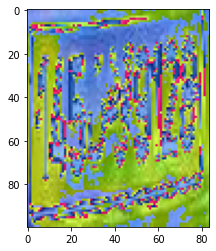

In [15]:

device = torch.device('cpu')
train_dataset = LinRegDataset(paths= train_samples.loc[:, 'new_path'].values, 
                              text = train_samples.loc[:, 'text'].values, 
                              transform_aug= eval_transforms_aug)

train_loader = DataLoader(dataset=train_dataset, batch_size= 1,
                            shuffle=True, collate_fn= lin_collate_fn)

for idx, data in enumerate(train_loader):
    imgs, targets, target_length = [d.to(device) for d in data]
    img = imgs[0]
    img = transforms.ToPILImage()(img)
    print(np.array(img).shape)
    plt.imshow(img)
    
    if idx == 0:
        break


In [16]:

# training 
def train_batch(model, train_loader, optimizer, device,):
    model.train()
    total_loss = 0
    bar = tqdm(train_loader, total=len(train_loader), desc='Model training')

    for data in bar:
        imgs, targets, target_length = [d.to(device) for d in data]
        #print('img batch\n',img.size(), targets.size(), target_length)
        preds, loss = model(imgs, targets, target_length)
       
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
    return total_loss/len(train_loader)


def train_aug(train_df, train_transforms_aug, device, model, optimizer,):
    
    print('-'*10, 'train data aug begins', '-'*10)
    total_aug_loss_lst = []
    for idx_aug, aug in enumerate(train_transforms_aug[:-1]):
        print(f"Aug: {idx_aug+1}/{len(train_transforms_aug[:-1])}")

        if idx_aug == 0:
            aug_t = [train_transforms_aug[-1]]
        else:
            aug_t = [aug] + [train_transforms_aug[-1]]
        train_dataset = LinRegDataset(train_df.loc[:, 'new_path'].values, train_df.loc[:, 'text'], aug_t )
        train_loader = DataLoader(train_dataset, batch_size= train_config['batch_size'], shuffle=True, collate_fn= lin_collate_fn)
        total_aug_loss = train_batch(model, train_loader, optimizer, device)
        total_aug_loss_lst.append(total_aug_loss)
        print(f"Aug {idx_aug+1} Loss: {total_aug_loss}")
    print('-'*10, 'train data aug ends', '-'*10)

    return sum(total_aug_loss_lst)/ len(total_aug_loss_lst)

 
 # evaluation 
def evaluate(model, valid_loader, device):
    
    model.eval()
    total_loss = 0
    total_log_loss = 0
    total_preds = []

    bar = tqdm(valid_loader, total=len(valid_loader), desc= "Evaluation")

    with torch.no_grad():
        for data in bar:
            imgs, targets, target_length = [d.to(device) for d in data]
            preds, loss = model(imgs, targets, target_length)
          
            total_loss += loss.item()
            total_preds.append(preds)

    return total_preds, total_loss/len(valid_loader)

  

def train_model(train_df, valid_df, train_transforms_aug, eval_transforms_aug):
    epochs = train_config['epochs']
    lr = train_config['lr']
    checkpoint_dir = train_config['checkpoint_dir']
    load_checkpoint_dir = train_config['load_checkpoint_dir']
    load_checkpoint = train_config['load_checkpoint']
    iter = 1
    best_loss = float('inf')
    num_class = len(LinRegDataset.CHAR2LABEL) + 1
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'device: {device}')

    # Eval
    valid_dataset = LinRegDataset(paths= valid_df.loc[:, 'new_path'].values,
                                  text = valid_df.loc[:, 'text'].values,
                                  transform_aug= eval_transforms_aug)
    
    valid_loader = DataLoader(valid_dataset, shuffle=False, batch_size = train_config['batch_size'],
                              collate_fn= lin_collate_fn, drop_last=True)

    # model    
    crnn = CRNN(img_channel= 3, num_class = num_class, rnn_hidden =  model_config['rnn_hidden'])
    
    # base model
    if load_checkpoint:
        print('Loading base checkpoint...')
        checkpoint = torch.load(load_checkpoint_dir, map_location= torch.device('cpu'))
        crnn.load_state_dict(checkpoint['model'])
        best_loss = checkpoint['valid_loss']
        iter = checkpoint['iteration'] + 1
        lr = checkpoint['lr']
        print(f'Current lr: {lr:.10f}')
        print(f"Loaded base checkpoint, best_valid_loss: {best_loss:.4f}, train_loss: {checkpoint['train_loss']:.4f}, iteration: {checkpoint['iteration']}")

    crnn.to(device)
    optimizer = optim.Adam(crnn.parameters(), lr= lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, factor=0.8, 
                                                     patience=5, verbose = True)

    for epoch in range(iter, epochs+iter):
        print(f'\nEpoch: {epoch}')

        train_loss = train_aug(train_df = train_df, train_transforms_aug = train_transforms_aug,
                               device = device, model = crnn, optimizer = optimizer)
        preds, valid_loss = evaluate(model = crnn, valid_loader = valid_loader, device = device)
     
        if valid_loss < best_loss: 
            best_loss = valid_loss
            torch.save({
                    'model': crnn.state_dict(),
                    'train_loss': train_loss,
                    'iteration': epoch,
                    'valid_loss': valid_loss,
                    'lr': optimizer.param_groups[0]['lr'],
            }, os.path.join(train_config['checkpoint_dir']))

        print(f"Epoch: {epoch}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}, Best Valid Loss: {best_loss:.4f}")
        print('-' * 50)
        scheduler.step(valid_loss)
        

In [17]:

def decode_pred(preds, label2char, blank=0):
    preds = preds.permute(1, 0, 2)
    preds = torch.softmax(preds, 2)
    preds = torch.argmax(preds, 2)
    preds = preds.detach().cpu().numpy()
    # print('pred decode', preds)

    all_preds = []
    for i in range(preds.shape[0]):
        temp = []
        for j in preds[i, :]:
            #j = j - 1
            if j == blank:
                temp.append("§")
            else:
                p = label2char[j]
                temp.append(p)

        tp = ''.join(temp).replace("§", "")
        all_preds.append(remove_duplicates(tp))
    return all_preds


def remove_duplicates(x):
    if len(x) < 2:
        return x
    fin = ""
    for j in x:
        if fin == "":
            fin = j
        else:
            if j == fin[-1]:
                continue
            else:
                fin = fin + j
    return fin



In [22]:

train_model(train_samples, valid_samples, train_transforms_aug, eval_transforms_aug)


device: cpu
Loading base checkpoint...
Current lr: 0.0003000000
Loaded base checkpoint, best_valid_loss: 0.0905, train_loss: 0.1679, iteration: 90

Epoch: 91
---------- train data aug begins ----------
Aug: 1/3


Model training: 100%|██████████| 23/23 [00:10<00:00,  2.29it/s]


Aug 1 Loss: 0.15779218887505325
Aug: 2/3


Model training: 100%|██████████| 23/23 [00:10<00:00,  2.29it/s]


Aug 2 Loss: 0.14818919612013776
Aug: 3/3


Model training: 100%|██████████| 23/23 [00:10<00:00,  2.27it/s]


Aug 3 Loss: 0.15121072692715604
---------- train data aug ends ----------


Evaluation: 100%|██████████| 5/5 [00:01<00:00,  3.87it/s]


Epoch: 91, Train Loss: 0.1524, Valid Loss: 0.1054, Best Valid Loss: 0.0905
--------------------------------------------------

Epoch: 92
---------- train data aug begins ----------
Aug: 1/3


Model training: 100%|██████████| 23/23 [00:09<00:00,  2.31it/s]


Aug 1 Loss: 0.13778478878995645
Aug: 2/3


Model training: 100%|██████████| 23/23 [00:10<00:00,  2.28it/s]


Aug 2 Loss: 0.14166614073126213
Aug: 3/3


Model training: 100%|██████████| 23/23 [00:10<00:00,  2.28it/s]


Aug 3 Loss: 0.13850754823373712
---------- train data aug ends ----------


Evaluation: 100%|██████████| 5/5 [00:01<00:00,  3.79it/s]


Epoch: 92, Train Loss: 0.1393, Valid Loss: 0.0976, Best Valid Loss: 0.0905
--------------------------------------------------

Epoch: 93
---------- train data aug begins ----------
Aug: 1/3


Model training: 100%|██████████| 23/23 [00:10<00:00,  2.29it/s]


Aug 1 Loss: 0.1305006172346032
Aug: 2/3


Model training: 100%|██████████| 23/23 [00:10<00:00,  2.27it/s]


Aug 2 Loss: 0.12348334248299184
Aug: 3/3


Model training: 100%|██████████| 23/23 [00:10<00:00,  2.26it/s]


Aug 3 Loss: 0.13991426255391992
---------- train data aug ends ----------


Evaluation: 100%|██████████| 5/5 [00:01<00:00,  3.84it/s]


Epoch: 93, Train Loss: 0.1313, Valid Loss: 0.1014, Best Valid Loss: 0.0905
--------------------------------------------------

Epoch: 94
---------- train data aug begins ----------
Aug: 1/3


Model training: 100%|██████████| 23/23 [00:10<00:00,  2.28it/s]


Aug 1 Loss: 0.12253607356030008
Aug: 2/3


Model training: 100%|██████████| 23/23 [00:10<00:00,  2.25it/s]


Aug 2 Loss: 0.1202365598924782
Aug: 3/3


Model training: 100%|██████████| 23/23 [00:10<00:00,  2.27it/s]


Aug 3 Loss: 0.12325205783481183
---------- train data aug ends ----------


Evaluation: 100%|██████████| 5/5 [00:01<00:00,  3.76it/s]


Epoch: 94, Train Loss: 0.1220, Valid Loss: 0.1037, Best Valid Loss: 0.0905
--------------------------------------------------

Epoch: 95
---------- train data aug begins ----------
Aug: 1/3


Model training: 100%|██████████| 23/23 [00:10<00:00,  2.26it/s]


Aug 1 Loss: 0.10812012673072192
Aug: 2/3


Model training: 100%|██████████| 23/23 [00:10<00:00,  2.27it/s]


Aug 2 Loss: 0.12406505093626354
Aug: 3/3


Model training: 100%|██████████| 23/23 [00:10<00:00,  2.27it/s]


Aug 3 Loss: 0.12548965118501498
---------- train data aug ends ----------


Evaluation: 100%|██████████| 5/5 [00:01<00:00,  3.87it/s]

Epoch: 95, Train Loss: 0.1192, Valid Loss: 0.1032, Best Valid Loss: 0.0905
--------------------------------------------------


In [90]:
def predict(path:str, test_df, eval_transforms_aug, transform):

    wrong_cases = []
    total_correct = 0
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Datasets
    test_dataset = LinRegDataset(test_df.loc[:, 'new_path'].values, None,
                                   eval_transforms_aug)
    
    # data loader
    test_loader = DataLoader(dataset=test_dataset, batch_size= 1, shuffle=False)
   
    # model    
    model = CRNN(3, len(LinRegDataset.CHAR2LABEL) +1,
                 rnn_hidden = model_config['rnn_hidden'])

    print('Loading base checkpoint...')
    checkpoint = torch.load(path, map_location= torch.device('cpu'))
    model.load_state_dict(checkpoint['model'])
    model.to(device)
    model.eval()
    print(f"Loaded base checkpoint, best_valid_loss: {checkpoint['valid_loss']:.4f}, train_loss: {checkpoint['train_loss']:.4f}, iteration: {checkpoint['iteration']}")
    

    for idx, img_data in enumerate(zip(test_loader, test_df.loc[:, 'new_path'])):
        data, path = img_data
        img = data.to(device)
        preds, loss = model(img)
        decoded = decode_pred(preds, LinRegDataset.LABEL2CHAR)

        print(decoded[0])
        img =transform(image = np.array(Image.open(path)))['image']
        plt.imshow(transforms.ToPILImage()(img))
        plt.show()
        print()

        if idx == 20:
            break



Loading base checkpoint...
Loaded base checkpoint, best_valid_loss: 0.0905, train_loss: 0.1679, iteration: 90
17T3989


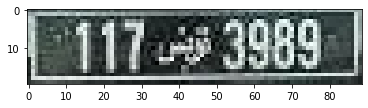


128T8086


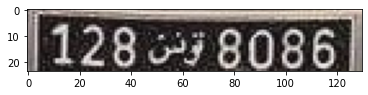


94T3458


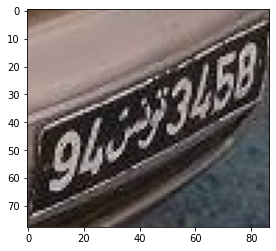


13T6719


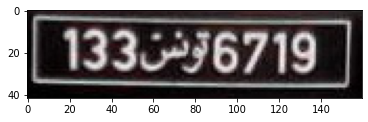


68T5979


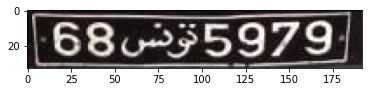


17T260


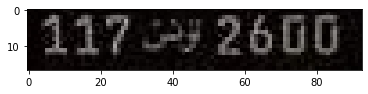


93T59


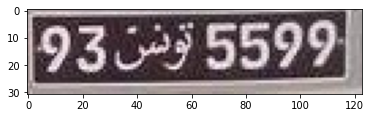


15T1216


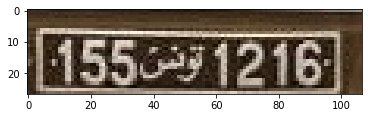


191T2827


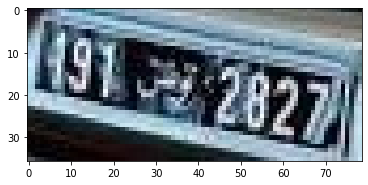


96T857


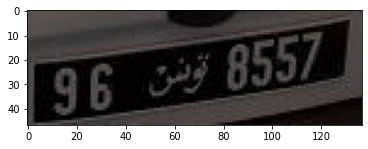


152T8269


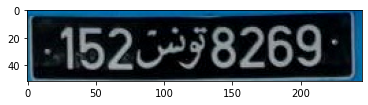


127T9295


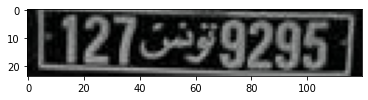


18T956


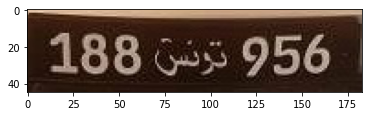


179T7121


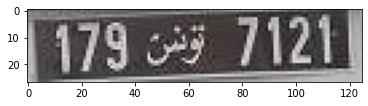


169T9685


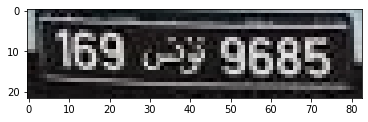


161T3230


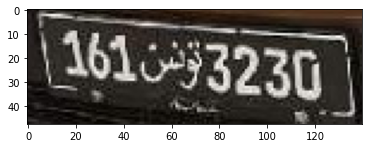


137T515


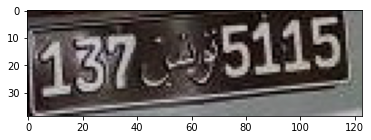


156T2325


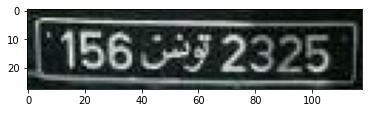


169T9685


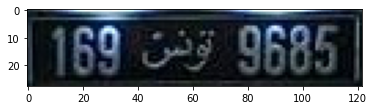


134T3970


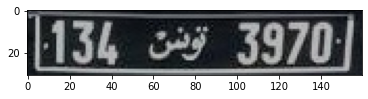


120T5039


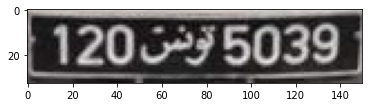

In [91]:
# train predictions
transform = A.Compose([A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p =0.5)])
path = train_config['checkpoint_dir']

predict(path, train_samples, eval_transforms_aug, transform)
